In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

from pprint import pprint
from trade_metrics import Metrics

sns.set_style('whitegrid')
plt.rcParams['axes.edgecolor'] = 'k'
plt.rcParams['lines.linewidth'] = 1

In [3]:
def growth(series):
    return (1 + series).cumprod() - 1

In [4]:
stock = 'MSFT'

start = '2022-01-01'
end = '2023-06-01'

data = yf.download(stock, start, end)

factor_vars = ['Open', 'High', 'Volume']
target_var = 'Adj Close'

factors = data[factor_vars][1:]
prices = data[target_var]
prices.name = stock
target = prices.pct_change()[1:]

[*********************100%***********************]  1 of 1 completed


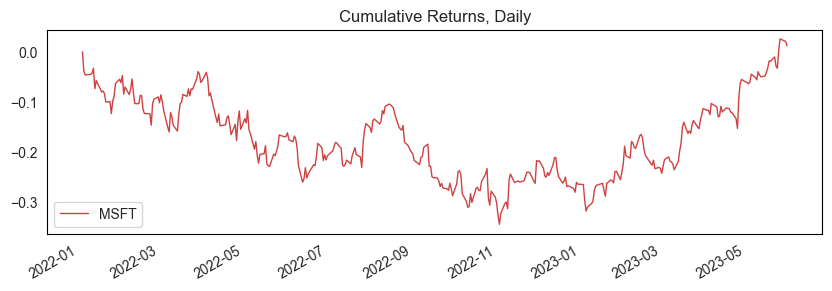

In [5]:
target.loc[target.index.min()] = 0
growth(target).plot(figsize=(10, 3), grid=False, color='#CE4242')
plt.title(f"Cumulative Returns, Daily")
plt.xlabel('')
plt.legend();

In [5]:
metrics = Metrics({'MSFT': target})
metrics.calculate()

,Cumulative Return,Annual Return,Annual Volatility,Sharpe Ratio,Max Drawdown
MSFT,0.012199,0.065468,0.337916,0.134554,-0.344549


In [6]:
factors.head(3)

,Open,High,Volume
Date,,,
2022-01-04,334.829987,335.200012,32674300
2022-01-05,325.859985,326.070007,40054300
2022-01-06,313.149994,318.700012,39646100


In [7]:
target.head(3)

Date
2022-01-04    0.000000
2022-01-05   -0.038388
2022-01-06   -0.007902
Name: MSFT, dtype: float64

In [8]:
window = 20
factors[f'{window}D_MA'] = prices[1:].rolling(window).mean()
factors[f'{window}D_Volatility'] = target.rolling(window).std() * np.sqrt(252)
factors = factors[window:]
target = target[window:]
factors.head(3)

,Open,High,Volume,20D_MA,20D_Volatility
Date,,,,,
2022-02-02,309.630005,315.119995,36636000,301.759146,0.313457
2022-02-03,309.489990,311.230011,43730000,301.014749,0.314326
2022-02-04,300.209991,308.799988,35096500,300.624101,0.319732


In [9]:
cpi = pd.read_csv('data/cpi.csv', index_col='DATE', parse_dates=True)
daily_inflation = cpi.pct_change(12).resample('D').interpolate('akima')
daily_inflation = daily_inflation.reindex(factors.index)
daily_inflation.rename(
    columns={
        'CPI': 'Inflation'
    }, inplace=True
)
daily_inflation.head(3)

,Inflation
Date,
2022-02-02,0.078854
2022-02-03,0.079020
2022-02-04,0.079206


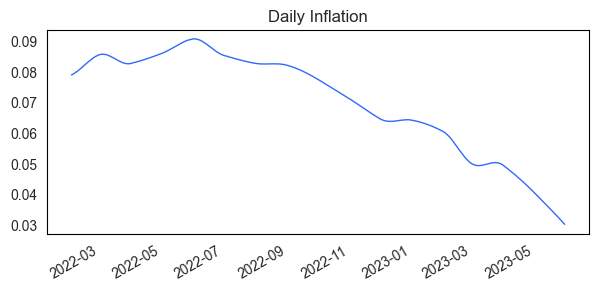

In [10]:
daily_inflation.plot(figsize=(7, 3), legend=False, grid=False, color='#3169FD')
plt.xlabel('')
plt.title('Daily Inflation');

In [11]:
factors['Inflation'] = daily_inflation
factors.head(3)

,Open,High,Volume,20D_MA,20D_Volatility,Inflation
Date,,,,,,
2022-02-02,309.630005,315.119995,36636000,301.759146,0.313457,0.078854
2022-02-03,309.489990,311.230011,43730000,301.014749,0.314326,0.079020
2022-02-04,300.209991,308.799988,35096500,300.624101,0.319732,0.079206


In [12]:
factors.isnull().sum()

Open              0
High              0
Volume            0
20D_MA            0
20D_Volatility    0
Inflation         0
dtype: int64

In [13]:
target.isnull().sum()

0

In [14]:
factors = factors.pct_change()[1:]
target = target[1:]

In [15]:
from sklearn.model_selection import train_test_split

seed = 88
test_size = 0.3

X = factors
y = target

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, random_state=seed, test_size=test_size)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((232, 6), (100, 6), (232,), (100,))

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

def mean_cv(estimator, name, X, y, scoring):
    cv = cross_validate(
        estimator,
        X,
        y,
        cv=5,
        scoring=scoring,
        return_train_score=True
    )
    cv = {k: np.mean(v) for k, v in cv.items()}
    cv = pd.DataFrame.from_dict(
        cv,
        orient='index'
    ).T
    cv.drop(['fit_time', 'score_time'], axis=1, inplace=True)
    cv.rename(columns={
        col: col.replace('_', ' ').title() for col in cv.columns
    }, inplace=True)
    cv['Model'] = name
    return cv.set_index('Model')

def run_gridsearch(estimator, param_grid, X, y, scoring, verbose=2):
    search = GridSearchCV(
        estimator=estimator,
        scoring=scoring,
        param_grid=param_grid,
        cv=5,
        n_jobs=-1,
        verbose=verbose,
    )
    search.fit(X, y)
    return search, search.best_estimator_, search.best_params_

cvs = []
scoring = 'neg_root_mean_squared_error'

In [17]:
model_1 = 'Linear Regression'
linreg_pipe = make_pipeline(StandardScaler(), LinearRegression())
linreg_cv = -mean_cv(
    linreg_pipe, 
    model_1,
    X_train, 
    y_train, 
    scoring
)

cvs.append(linreg_cv)

linreg_cv

,Test Score,Train Score
Model,,
Linear Regression,0.013659,0.012558


In [18]:
from sklearn.tree import DecisionTreeRegressor

model_2 = 'Decision Tree'
tree_pipe = make_pipeline(
    StandardScaler(), 
    DecisionTreeRegressor(random_state=seed)
)

tree_cv = -mean_cv(
    tree_pipe,
    model_2,
    X_train,
    y_train,
    scoring
)

cvs.append(tree_cv)

tree_cv

,Test Score,Train Score
Model,,
Decision Tree,0.019311,-0.0


In [19]:
import warnings
warnings.filterwarnings('ignore')

param_grid_1 = {
    # Function to measure the quality of a split
    'decisiontreeregressor__criterion': ['mse', 'friedman_mse', 'mae'],  
    # Strategy used to choose the split at each node
    'decisiontreeregressor__splitter': ['best', 'random'],  
    # Maximum depth of the tree
    'decisiontreeregressor__max_depth': [None, 10, 20, 30, 40, 50],  
    # Minimum number of samples required to split an internal node
    'decisiontreeregressor__min_samples_split': [2, 5, 10],  
    # Minimum number of samples required to be at a leaf node
    'decisiontreeregressor__min_samples_leaf': [1, 2, 4],  
    # Number of features to consider when looking for the best split
    'decisiontreeregressor__max_features': ['auto', 'sqrt', 'log2'],  
}

tree_search, tree_search_BE, tree_search_BP = run_gridsearch(
    tree_pipe,
    param_grid_1,
    X_train,
    y_train,
    scoring=scoring,
)

Fitting 5 folds for each of 972 candidates, totalling 4860 fits


In [20]:
pprint(tree_search_BP)

{'decisiontreeregressor__criterion': 'friedman_mse',
 'decisiontreeregressor__max_depth': 10,
 'decisiontreeregressor__max_features': 'auto',
 'decisiontreeregressor__min_samples_leaf': 4,
 'decisiontreeregressor__min_samples_split': 10,
 'decisiontreeregressor__splitter': 'random'}


In [21]:
model_3 = 'Tuned Decision Tree'
tuned_tree_pipe = tree_search_BE
tuned_tree_cv = -mean_cv(
    tuned_tree_pipe,
    model_3,
    X_train,
    y_train,
    scoring
)

cvs.append(tuned_tree_cv)

tuned_tree_cv

,Test Score,Train Score
Model,,
Tuned Decision Tree,0.015691,0.013905


In [22]:
from sklearn.ensemble import RandomForestRegressor

model_4 = 'Random Forest'
forest_pipe = make_pipeline(
    StandardScaler(), 
    RandomForestRegressor(random_state=seed)
)

forest_cv = -mean_cv(
    forest_pipe,
    model_4,
    X_train,
    y_train,
    scoring
)

cvs.append(forest_cv)

forest_cv

,Test Score,Train Score
Model,,
Random Forest,0.014555,0.005481


In [23]:
param_grid_2 = {
    'randomforestregressor__n_estimators': [50, 100, 200],
    'randomforestregressor__max_depth': [None, 10, 20, 30],
    'randomforestregressor__min_samples_split': [2, 5, 10],
    'randomforestregressor__min_samples_leaf': [1, 2, 4],
    'randomforestregressor__max_features': ['auto', 'sqrt', 'log2'],
    'randomforestregressor__bootstrap': [True, False]
}

forest_search, forest_search_BE, forest_search_BP = run_gridsearch(
    forest_pipe,
    param_grid_2,
    X_train,
    y_train,
    scoring
)

Fitting 5 folds for each of 648 candidates, totalling 3240 fits


In [24]:
pprint(forest_search_BP)

{'randomforestregressor__bootstrap': True,
 'randomforestregressor__max_depth': None,
 'randomforestregressor__max_features': 'auto',
 'randomforestregressor__min_samples_leaf': 4,
 'randomforestregressor__min_samples_split': 2,
 'randomforestregressor__n_estimators': 200}


In [25]:
model_5 = 'Tuned Random Forest'
tuned_forest_pipe = forest_search_BE
tuned_forest_cv = -mean_cv(
    tuned_forest_pipe,
    model_5,
    X_train,
    y_train,
    scoring
)

cvs.append(tuned_forest_cv)

tuned_forest_cv

,Test Score,Train Score
Model,,
Tuned Random Forest,0.013826,0.008651


In [38]:
stats = pd.concat(cvs)
stats = stats.sort_values(by='Test Score', ascending=False)
stats.iloc[::-1]

,Test Score,Train Score
Model,,
Linear Regression,0.013659,0.012558
Tuned Random Forest,0.013826,0.008651
Random Forest,0.014555,0.005481
Tuned Decision Tree,0.015691,0.013905
Decision Tree,0.019311,-0.000000


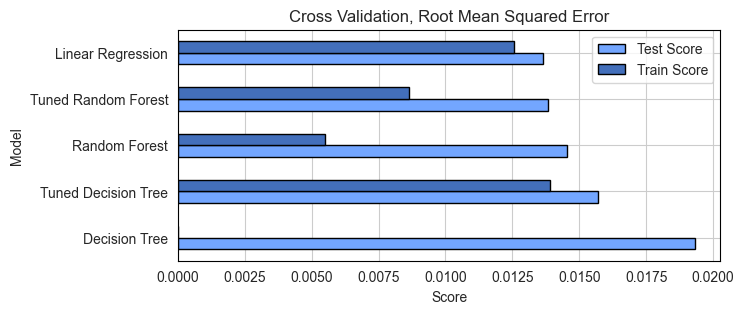

In [44]:
ax1 = stats.plot.barh(
    figsize=(7,3), 
    edgecolor='k', 
    color=['#73A6FF', '#436FBB']
)


plt.title('Cross Validation, Root Mean Squared Error')
plt.xlabel('Score')
plt.legend(bbox_to_anchor=(1,1));

In [27]:
from sklearn.metrics import precision_score, accuracy_score

y_test_binary = np.sign(y_test)

linreg_pipe.fit(X_train, y_train)
y_pred_linreg = linreg_pipe.predict(X_test)
y_pred_linreg_binary = np.sign(y_pred_linreg)

precision_linreg = precision_score(y_test_binary, y_pred_linreg_binary)
acc_linreg = accuracy_score(y_test_binary, y_pred_linreg_binary)

print(f'''Precision Score of Best Regressor \
Classification on Unseen Data: {precision_linreg:,.4f}''')
print(f'''Accuracy Score of Best Regressor \
Classification on Unseen Data: {acc_linreg:,.4f}''')

Precision Score of Best Regressor Classification on Unseen Data: 0.7288
Accuracy Score of Best Regressor Classification on Unseen Data: 0.7600


In [28]:
from sklearn.linear_model import LogisticRegression

y_train_binary = np.sign(y_train)

clsf_cvs = []

model_6 = 'Logistic Regression'
logreg_pipe = make_pipeline(
    StandardScaler(), 
    LogisticRegression(random_state=seed)
)

logreg_cv = mean_cv(
    logreg_pipe,
    model_6,
    X_train,
    y_train_binary,
    'precision'
)

clsf_cvs.append(logreg_cv)

logreg_cv

,Test Score,Train Score
Model,,
Logistic Regression,0.775922,0.804371


In [29]:
param_grid_3 = {
    'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'logisticregression__penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'logisticregression__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'logisticregression__max_iter': [50, 100, 200]
}

logreg_search, logreg_search_BE, logreg_search_BP = run_gridsearch(
    logreg_pipe,
    param_grid_3,
    X_train,
    y_train_binary,
    'precision'
)

Fitting 5 folds for each of 420 candidates, totalling 2100 fits


In [30]:
model_7 = 'Tuned Logistic Regression'
tuned_logreg_pipe = logreg_search_BE
tuned_logreg_cv = mean_cv(
    tuned_logreg_pipe,
    model_7,
    X_train,
    y_train_binary,
    'precision'
)

clsf_cvs.append(tuned_logreg_cv)

tuned_logreg_cv

,Test Score,Train Score
Model,,
Tuned Logistic Regression,0.816667,0.862416


In [31]:
pprint(logreg_search_BP)

{'logisticregression__C': 0.01,
 'logisticregression__max_iter': 50,
 'logisticregression__penalty': 'l2',
 'logisticregression__solver': 'newton-cg'}


In [39]:
clsf_stats = pd.concat(clsf_cvs)
clsf_stats = clsf_stats.sort_values(by='Test Score', ascending=False)
clsf_stats

,Test Score,Train Score
Model,,
Tuned Logistic Regression,0.816667,0.862416
Logistic Regression,0.775922,0.804371


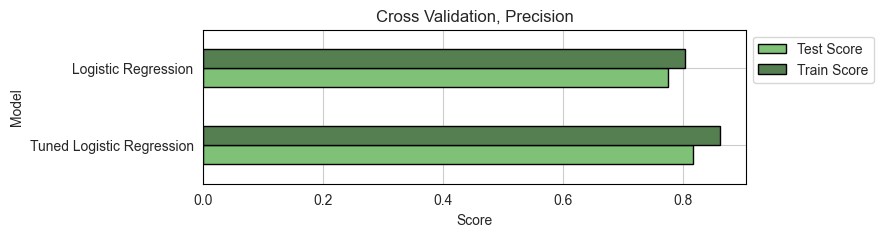

In [43]:
ax2 = clsf_stats.plot.barh(
    figsize=(7,2), 
    edgecolor='k', 
    color=['#7EC177', '#557E51']
)

plt.title('Cross Validation, Precision')
plt.xlabel('Score')
plt.legend(bbox_to_anchor=(1,1));

In [33]:
tuned_logreg_pipe.fit(X_train, y_train_binary)
y_pred_logreg = tuned_logreg_pipe.predict(X_test)

precision_tuned_logreg = precision_score(y_test_binary, y_pred_logreg)
acc_tuned_logreg = accuracy_score(y_test_binary, y_pred_logreg)

print(f'''Precision Score of Tuned Logistic Regression \
on Unseen Data: {precision_tuned_logreg:,.4f}''')
print(f'''Accuracy Score of Tuned Logistic Regression \
on Unseen Data: {acc_tuned_logreg:,.4f}''')

Precision Score of Tuned Logistic Regression on Unseen Data: 0.8511
Accuracy Score of Tuned Logistic Regression on Unseen Data: 0.8200


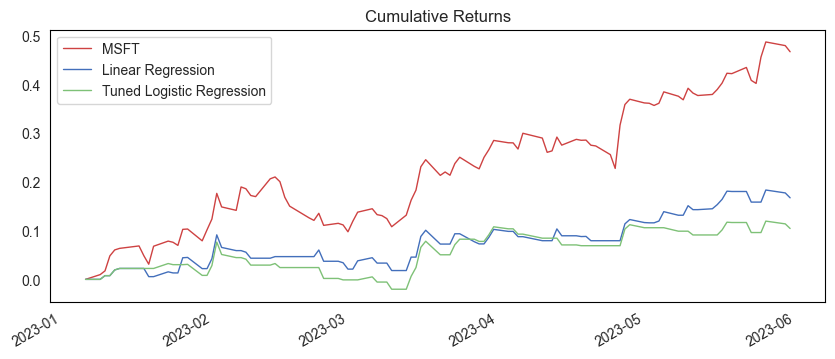

In [60]:
backtest = pd.DataFrame(y_test)
start_idx = backtest.index.min()

backtest['linreg_signal'] = y_pred_linreg_binary
backtest['tuned_logreg_signal'] = y_pred_logreg

for signal in ['linreg', 'tuned_logreg']:
    signal_name = f'{signal}_signal'
    backtest[signal_name] = backtest[signal_name].replace(-1, np.nan)
    backtest[signal_name] = backtest[signal_name].shift()
    strat_returns = backtest[stock] * backtest[signal_name]
    backtest[f'{signal}_returns'] = strat_returns
    backtest[f'{signal}_returns'].loc[start_idx] = 0
    backtest[f'{signal}_growth'] = growth(backtest[f'{signal}_returns'])

backtest[stock].loc[start_idx] = 0
backtest[f'{stock}_growth'] = growth(backtest[stock])
cols = [f'{stock}_growth', 'linreg_growth', 'tuned_logreg_growth']
new_cols = ['MSFT', 'Linear Regression', 'Tuned Logistic Regression']

backtest[cols].rename(columns={
    col: new_col for col, new_col in zip(
        cols, new_cols
    )
}).ffill().plot(
    figsize=(10, 4),
    color=['#CE4242', '#436FBB', '#7EC177'],
    grid=False
)

plt.title('Cumulative Returns')
plt.xlabel('');

In [59]:
base_rets = backtest[stock]
linreg_rets = backtest['linreg_returns'].ffill()
tuned_logreg_rets = backtest['tuned_logreg_returns'].ffill()

bt_metrics = Metrics({
    f'{stock}': base_rets,
    'Linear Regression': linreg_rets,
    'Tuned Logistic Regression': tuned_logreg_rets
})

bt_metrics.calculate()

,Cumulative Return,Annual Return,Annual Volatility,Sharpe Ratio,Max Drawdown
MSFT,0.466822,1.006192,0.282337,3.492963,-0.092895
Linear Regression,-0.089599,-0.210085,0.231467,-0.994030,-0.165068
Tuned Logistic Regression,-0.215648,-0.590407,0.206413,-2.957210,-0.271763
